# DeepSORVF: Deep Learning-based Simple Online and Real-Time Vessel Data Fusion Method

DeepSORVF is an AIS and video data fusion method.

## 1. Environment Set-up

In [80]:
!pip install datetime pandas matplotlib fastdtw imutils geopy pyproj easydict opencv-python

     -------------------------------------- 52.1/52.1 kB 140.9 kB/s eta 0:00:00
     ------------------------------------- 204.0/204.0 kB 44.6 kB/s eta 0:00:00


Select the appropriate version of pytorch.

In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [83]:
import torch
torch.__version__

'1.13.1+cu117'

## 2. Download Model

Download [ckpt.t7](https://drive.google.com/file/d/1QdIP5TEDALJnnpqwjXwvL1J_GoseTK9D/view?usp=share_link) and save to `DeepSORVF/deep_sort/deep_sort/deep/checkpoint/` folder. Download [YOLOX-final.pth](https://drive.google.com/file/d/1mhah7ZzP8oAUuSMR96Or9UvqkXe-AMuS/view?usp=share_link) and save to `DeepSORVF/detection_yolox/model_data/` folder.

## 3. Download Data

Download sample data [clip-01](https://drive.google.com/file/d/1Bns1jAW1ImL-FeCQBvIUcrO0hjYLIB5K/view?usp=share_link).

## 4. Visualize Data

In [65]:
# Video Data
import cv2, imutils
cap = cv2.VideoCapture('./clip-01/2022_06_04_12_05_12_12_07_02_b.mp4')

_, im = cap.read()
result = imutils.resize(im, height=500)

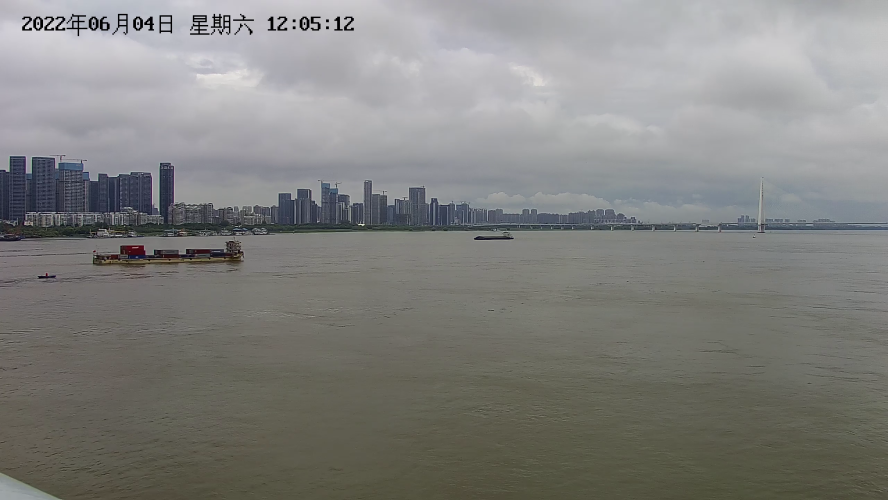

In [66]:
Image.fromarray(result[:,:,::-1])

In [67]:
# camera parameters
import glob
with open(glob.glob('./clip-01/camera_para.txt')[0], "r") as f:
    camera_para = f.readlines()[0][1:-2]
    camera_para = camera_para.split(',')
    camera_para = list(map(float,camera_para))

In [68]:
camera_para

[114.32722222222222,
 30.60027777777778,
 352.0,
 -4.0,
 20.0,
 55.0,
 30.94,
 2391.26,
 2446.89,
 1305.04,
 855.21]

In [69]:
# AIS Data
import pandas as pd
path = './clip-01/ais/2022_06_04_12_05_12.csv'
ais_data = pd.read_csv(path, usecols=[1, 2, 3, 4, 5, 6, 7, 8], header=0)

In [70]:
ais_data

,mmsi,lon,lat,speed,course,heading,type,timestamp
0,110000000,114.325830,30.601158,0.9,142.5,511,18,1654315502004
1,130000000,114.319323,30.615373,0.1,120.0,203,3,1654315422867
2,140000000,114.332392,30.616292,8.4,48.1,511,18,1654315019171
3,150000000,114.307825,30.596593,2.8,222.5,511,18,1654315505722
4,160000000,114.317922,30.614342,0.0,0.0,511,18,1654315292055
5,200000000,114.317772,30.614052,0.1,126.1,126,18,1654315334484
6,210000000,114.320187,30.606670,3.8,214.3,511,18,1654315472852
7,220000000,114.317220,30.603828,2.3,219.8,219,1,1654315464601
8,230000000,114.299270,30.583418,3.4,199.3,511,18,1654315224349
9,240000000,114.297535,30.580717,3.2,205.6,0,1,1654314955433


## 5. Start Running

In [71]:
import os, time, imutils, cv2, argparse
import pandas as pd
import numpy as np

# read data
from utils.file_read import read_all, ais_initial, update_time, time2stamp

# AIS Video Fusion package
from utils.AIS_utils import AISPRO
from utils.VIS_utils import VISPRO
from utils.FUS_utils import FUSPRO

# Show the fusion results on the Video
from utils.draw import DRAW

# Save the detection tracking and fusion files
from utils.gen_result import gen_result


In [72]:
# Parameter Settings
data_path = './clip-01/'
result_path = './result/'
anti = 1
anti_rate = 0
video_path, ais_path, result_video, result_metric, initial_time,\
      camera_para = read_all(data_path, result_path)

# Initialization
ais_file, timestamp0, time0 = ais_initial(ais_path, initial_time)
Time = initial_time.copy()

cap = cv2.VideoCapture(video_path)
im_shape = [cap.get(3), cap.get(4)]
max_dis = min(im_shape)//2
fps = int(cap.get(5))
t = int(1000/fps)
    
AIS = AISPRO(ais_path, ais_file, im_shape, t) # ais path, ais file, im_shape, t
VIS = VISPRO(anti, anti_rate, t) # anti-occlusion, occlusion rate, t
FUS = FUSPRO(max_dis, im_shape, t) # max distance of matching, im_shape, t
DRA = DRAW(im_shape, t) # im_shape, t
    
name = 'demo'
show_size = 500
videoWriter = None
bin_inf = pd.DataFrame(columns=['ID', 'mmsi', 'timestamp', 'match'])

print('Start Time: %s || Stamp: %d || fps: %d' % (time0, timestamp0, fps))
times  = 0
time_i = 0
sum_t  = []


Start Time: 2022_06_04_12_05_12_000 || Stamp: 1654315512000 || fps: 25


In [74]:
# running
while True:
    # read frame
    _, im = cap.read()
    if im is None:
        break
    start = time.time()
        
    # update timestamp
    Time, timestamp, Time_name = update_time(Time, t)
    # =============================================================================
    #  1.AIS-based trajectory extraction. The AIS data is updated every second
    # =============================================================================
    AIS_vis, AIS_cur = AIS.process(camera_para, timestamp, Time_name)
    # =============================================================================
    #  2.Video-based trajectory extraction.
    # =============================================================================
    Vis_tra, Vis_cur = VIS.feedCap(im, timestamp, AIS_vis, bin_inf)
    # =============================================================================
    #  3.AIS/Video fusion
    # =============================================================================
    Fus_tra, bin_inf = FUS.fusion(AIS_vis, AIS_cur, Vis_tra, Vis_cur, timestamp)

    end = time.time() - start
    time_i = time_i + end
    if timestamp % 1000 < t:
        # Generate detection.txt tracking.txt fusion.txt
        gen_result(times, Vis_cur, Fus_tra, result_metric, im_shape)
        times = times+1
        sum_t.append(time_i)
        print('Time: %s || Stamp: %d || Process: %.6f || Average: %.6f +- %.6f'%(Time_name, timestamp, time_i, np.mean(sum_t), np.std(sum_t)))
        time_i = 0
    # =============================================================================
    #  4.Fusion result visualization
    # =============================================================================
    im = DRA.draw_traj(im, AIS_vis, AIS_cur, Vis_tra, Vis_cur, Fus_tra, timestamp)
    # =============================================================================
    #  Video display
    # =============================================================================
    result = im
    result = imutils.resize(result, height=show_size)
    if videoWriter is None:
        fourcc = cv2.VideoWriter_fourcc(
                'm', 'p', '4', 'v')
        videoWriter = cv2.VideoWriter(
                result_video, fourcc, fps, (result.shape[1], result.shape[0]))

    videoWriter.write(result)

    cv2.imshow(name, result)
    cv2.waitKey(1)
    if cv2.getWindowProperty(name, cv2.WND_PROP_AUTOSIZE) < 1:
    # x exist
        break   
cap.release()
videoWriter.release()
cv2.destroyAllWindows()

Time: 2022_06_04_12_05_13_000 || Stamp: 1654315513000 || Process: 0.406265 || Average: 0.406265 +- 0.000000
Time: 2022_06_04_12_05_14_000 || Stamp: 1654315514000 || Process: 0.245419 || Average: 0.325842 +- 0.080423
Time: 2022_06_04_12_05_15_000 || Stamp: 1654315515000 || Process: 0.236551 || Average: 0.296078 +- 0.077998
Time: 2022_06_04_12_05_16_000 || Stamp: 1654315516000 || Process: 0.239476 || Average: 0.281928 +- 0.071857
Time: 2022_06_04_12_05_17_000 || Stamp: 1654315517000 || Process: 0.237334 || Average: 0.273009 +- 0.066700
Time: 2022_06_04_12_05_18_000 || Stamp: 1654315518000 || Process: 0.248273 || Average: 0.268886 +- 0.061583
Time: 2022_06_04_12_05_19_000 || Stamp: 1654315519000 || Process: 0.250067 || Average: 0.266198 +- 0.057394
Time: 2022_06_04_12_05_20_000 || Stamp: 1654315520000 || Process: 0.259001 || Average: 0.265298 +- 0.053740
Time: 2022_06_04_12_05_21_000 || Stamp: 1654315521000 || Process: 0.255399 || Average: 0.264198 +- 0.050762
Time: 2022_06_04_12_05_22_00

Time: 2022_06_04_12_06_29_000 || Stamp: 1654315589000 || Process: 0.402390 || Average: 0.318683 +- 0.064124
Time: 2022_06_04_12_06_30_000 || Stamp: 1654315590000 || Process: 0.376863 || Average: 0.319429 +- 0.064046
Time: 2022_06_04_12_06_31_000 || Stamp: 1654315591000 || Process: 0.400530 || Average: 0.320456 +- 0.064282
Time: 2022_06_04_12_06_32_000 || Stamp: 1654315592000 || Process: 0.481108 || Average: 0.322464 +- 0.066326
Time: 2022_06_04_12_06_33_000 || Stamp: 1654315593000 || Process: 0.388121 || Average: 0.323274 +- 0.066313
Time: 2022_06_04_12_06_34_000 || Stamp: 1654315594000 || Process: 0.388331 || Average: 0.324068 +- 0.066293
Time: 2022_06_04_12_06_35_000 || Stamp: 1654315595000 || Process: 0.384925 || Average: 0.324801 +- 0.066226
Time: 2022_06_04_12_06_36_000 || Stamp: 1654315596000 || Process: 0.513517 || Average: 0.327048 +- 0.068939
Time: 2022_06_04_12_06_37_000 || Stamp: 1654315597000 || Process: 0.374288 || Average: 0.327603 +- 0.068722
Time: 2022_06_04_12_06_38_00